In [1]:
import os

import pandas as pd

In [2]:
filepath ='/home/yiyi/Documents/masterarbeit/CPD/data/cleand_query_output_csv/fc73c5ad-3748-4d31-8ab2-014c875b05d7'

In [3]:
from gensim.models import Word2Vec

import nltk
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn import cluster
from sklearn import metrics
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering

from utils import preprocess

from gensim import corpora, matutils, models, similarities
from gensim.similarities.docsim import MatrixSimilarity

unable to import 'smart_open.gcs', disabling that module


In [4]:
# Hilton miami downtown
# 2018-01-17T16:25:00+02:00
# 527 rooms
# 35 million renovation
# mammoth shopping complex, movie theater , 
# guest rooms, meeting space, restuarant, lobby, loading dock, park , 

In [5]:
anchors=[['room'],['meeting'],['restaurant'], ['parking', 'park'], ['renovation', 'renovate', 'make up']]

In [6]:
data, date, score = preprocess.get_data_list(filepath)

Elapsed time: 29.4302 seconds


In [15]:
score[:10]

[100.0, 20.0, 100.0, 80.0, 100.0, 100.0, 80.0, 100.0, 100.0, 100.0]

In [7]:
len(data), len(date), len(score)

(9776, 9776, 9776)

In [12]:
data_sents =[[' '.join(tokens)  for tokens in sublist] for sublist in data]

In [16]:
data_sents[:2]

[['stayed one suite floor',
  'two kid two adult',
  'pool really fantastic stress enough much enjoyed',
  'rubberized bottom stair scuffed knee snagged bathing suit',
  'hotel close family attraction wanted see sea aquarium jungle island daughter loved pool much could wait leave attraction go swimming',
  'also porter noticed one day daughter looked little getting elevator magic trick still talking family hotel'],
 ['stay hilton downtown miami hell day one',
  'overboked friend wait come back later get room reserved week ahead',
  'person checked u manager messed confirmation number check second day trip check back pay fee',
  'bar tender plum rude sexist friend sat bar minute bar tender completely ignored u continued wait male customer',
  'asked man next get drink since bar tender would wait man said would',
  'shower room timed yet every single time took shower cut without turning',
  'last night wild child running around pulled fire alarm woke whole hotel talking evacuating',
  'f

In [19]:
dates= [[date[i] for _  in range(len(data_sents[i]))] for i in range(len(data_sents))]
scores= [[score[i] for _  in range(len(data_sents[i]))] for i in range(len(data_sents))]

In [24]:
sents = [sent for sublist in data_sents for sent in sublist]
datess = [sent for sublist in dates for sent in sublist]
scoress= [sent for sublist in scores for sent in sublist]

In [25]:
len(sents), len(datess), len(scoress)

(44863, 44863, 44863)

In [26]:
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt

from corextopic import corextopic as ct
from corextopic import vis_topic as vt # jupyter notebooks will complain matplotlib is being loaded twice

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

/home/yiyi/anaconda3/envs/cdp/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [28]:
vectorizer = CountVectorizer(stop_words='english', max_features=20000, binary=True)
doc_word = vectorizer.fit_transform(sents)
doc_word = ss.csr_matrix(doc_word)

doc_word.shape # n_docs x m_words

(44863, 11536)

In [29]:
words = list(np.asarray(vectorizer.get_feature_names()))


In [30]:
not_digit_inds = [ind for ind,word in enumerate(words) if not word.isdigit()]
doc_word = doc_word[:,not_digit_inds]
words    = [word for ind,word in enumerate(words) if not word.isdigit()]

doc_word.shape # n_docs x m_words

(44863, 11536)

In [31]:
from corextopic import corextopic as ct

In [32]:
topic_model = ct.Corex(n_hidden=5, words=words, seed=1)


In [33]:
topic_model.fit( doc_word,
    words=words,
    anchors=anchors,
    anchor_strength=6
)

In [34]:

for n in range(len(anchors)):
    topic_words, _ = zip(*topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ','.join(topic_words))

0: room,view,clean,spacious,comfortable,floor,ready,bed,large,bay
1: meeting,desk,told,member,check,called,asked,manager,arrived,honor
2: restaurant,beach,south,bayside,close,distance,walking,arena,bus,publix
3: parking,park,valet,self,garage,expensive,car,pay,fee,cost
4: renovation,bathroom,air,shower,old,door,loud,water,dirty,need


In [36]:
topic_df = pd.DataFrame(
    topic_model.transform(doc_word),
    columns =['T_{}'.format(anchors[i][0]) for i in range(len(anchors))]
    ).astype(float)
topic_df['data']=sents
topic_df['date']= datess
topic_df['score']= scoress

In [40]:
topic_df.tail(5)

,T_room,T_meeting,T_restaurant,T_parking,T_renovation,data,date,score
44858,0.0,0.0,0.0,0.0,1.0,someone vomited carpet hallway stayed day,2020-01-01 00:00:00,60
44859,0.0,0.0,0.0,0.0,0.0,cleaning pretty bad,2020-01-01 00:00:00,60
44860,0.0,0.0,0.0,0.0,0.0,location good,2020-01-02 00:00:00,90
44861,0.0,0.0,0.0,0.0,0.0,free wifi,2020-01-02 00:00:00,90
44862,1.0,0.0,0.0,0.0,1.0,also like change elevator get street level mai...,2020-01-02 00:00:00,90


In [49]:
## check the score along the topic room/rennovation
df = topic_df[topic_df['T_room']==1.0][topic_df['T_renovation']==1.0].sort_values('date')

/home/yiyi/anaconda3/envs/cdp/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [95]:
df.head(20)

,T_room,T_meeting,T_restaurant,T_parking,T_renovation,data,date,score
1278,1.0,0.0,0.0,0.0,1.0,complaint room fan heater really work,2008-03-04 00:00:00,80
1570,1.0,1.0,0.0,0.0,1.0,receive non smoking room requested restroom clean,2008-03-18 00:00:00,80
2632,1.0,1.0,0.0,0.0,1.0,shut valve manually didnt bother repaired didn...,2008-03-23 00:00:00,40
4778,1.0,0.0,0.0,0.0,1.0,one thing note sounded like construction going...,2008-04-03 00:00:00,60
4206,1.0,0.0,0.0,0.0,1.0,little know next day would upgraded room size ...,2008-04-05 00:00:00,20
4209,1.0,1.0,0.0,0.0,1.0,saw someone else managing get internet asked r...,2008-04-05 00:00:00,20
3061,1.0,1.0,1.0,0.0,1.0,hilton downtown miami disaster recommend one r...,2008-04-07 00:00:00,20
3050,1.0,1.0,0.0,0.0,1.0,upon returning room first evening room door co...,2008-04-07 00:00:00,20
3048,1.0,1.0,0.0,0.0,1.0,told many unhappy customer would wait hour roo...,2008-04-07 00:00:00,20
3491,1.0,1.0,0.0,0.0,1.0,thirdly room booked available reason gave one ...,2008-04-15 00:00:00,60


In [74]:
df.iloc[588,:]

T_room                                                  1
T_meeting                                               0
T_restaurant                                            0
T_parking                                               0
T_renovation                                            1
data            bedbug outside window crawling glass room
date                                  2014-07-19 00:00:00
score                                                    
Name: 17595, dtype: object

In [76]:
df.drop(index=17595, inplace=True)

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import ruptures as rpt
import time


%matplotlib inline
def binseg(scores):
    # fast
    model = "l2"
    n_samples = scores.shape[0]
    algo = rpt.Binseg(model=model).fit(scores)
    try:
        my_bkps = algo.predict(n_bkps=5)
        print('change points:', my_bkps)
        # show results

        rpt.show.display(scores, my_bkps, figsize=(10, 6))
        plt.title('Change Point Detection: Binary Segmentation Search Method')
        plt.show()
    except Exception as msg:
        print(msg)

In [77]:
for idx, score in enumerate( df.score.to_list()):
    try:
        score= int(score)
    except Exception:
        print(idx, 'd')

In [79]:
scores= [int(score) for score in  df.score ]

change points: [40, 1110, 1190, 1295, 1345, 1551]


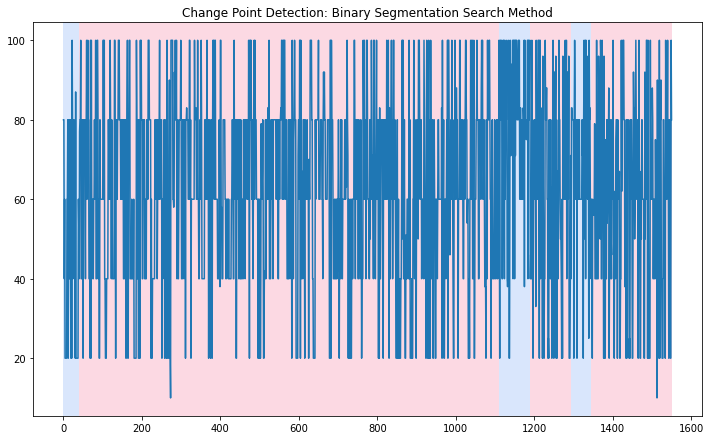

In [80]:
binseg(np.array(df.score.astype('int')))

In [99]:
df.iloc[1146,:]

T_room                                          1
T_meeting                                       0
T_restaurant                                    0
T_parking                                       0
T_renovation                                    1
data            air conditioner room cooling room
date                          2017-06-01 00:00:00
score                                          40
Name: 31774, dtype: object

In [82]:
df.iloc[1295,:]

T_room                                                          1
T_meeting                                                       1
T_restaurant                                                    0
T_parking                                                       0
T_renovation                                                    1
data            safe room work maintenance tried fix could cha...
date                                          2018-06-24 00:00:00
score                                                          83
Name: 36729, dtype: object

In [98]:
df.iloc[1210,:]

T_room                                         1
T_meeting                                      0
T_restaurant                                   0
T_parking                                      0
T_renovation                                   1
data            got room bit walk corridor issue
date                         2017-12-28 00:00:00
score                                        100
Name: 34105, dtype: object

In [87]:
df.iloc[1190,:]

T_room                                                          1
T_meeting                                                       0
T_restaurant                                                    0
T_parking                                                       1
T_renovation                                                    1
data            disapointed would apply gratuity self service ...
date                                          2017-09-30 00:00:00
score                                                          40
Name: 33273, dtype: object

In [89]:
df.iloc[1120,:]

T_room                                                     1
T_meeting                                                  0
T_restaurant                                               0
T_parking                                                  0
T_renovation                                               1
data            ac unit room noisy want change room complain
date                                     2017-04-12 00:00:00
score                                                     80
Name: 31113, dtype: object

In [94]:
df.to_csv('test.csv', index=False)